In [2]:
import sys
import numpy as np
import math
%matplotlib nbagg
import matplotlib.pyplot as plt

pulse_building_folder = '/Users/natalie/Documents/PhD/Qdev/QcodesRelated/Chickpea'
if pulse_building_folder not in sys.path:
    sys.path.insert(0, pulse_building_folder)

from chickpea import Waveform, Element, Sequence, Segment
from chickpea.segment_functions import flat, gaussian, gaussian_derivative 

### Make gate segments

In [3]:
x_y_pi_pulse = Segment(name='pi_pulse', gen_func=gaussian,
                       func_args={'sigma':10e-9, 'sigma_cutoff':4, 'amp':1})

x_y_pi_half_pulse = Segment(name='pi_pulse', gen_func=gaussian,
                            func_args={'sigma':10e-9, 'sigma_cutoff':4, 'amp':0.5})

In [4]:
x_y_pi_pulse_drag = Segment(name='pi_pulse_drag', gen_func=gaussian_derivative,
                            func_args={'sigma':10e-9, 'sigma_cutoff':4, 'amp':0.2})

x_y_pi_half_pulse_drag = Segment(name='pi_pulse_drag', gen_func=gaussian_derivative,
                                 func_args={'sigma':10e-9, 'sigma_cutoff':4, 'amp':0.1})

In [5]:
z_pi_pulse = Segment(name='z_gate', gen_func=gaussian,
                     func_args={'sigma':20e-9, 'sigma_cutoff':2, 'amp':1})

z_pi_half_pulse = Segment(name='z_gate', gen_func=gaussian,
                          func_args={'sigma':20e-9, 'sigma_cutoff':2, 'amp':0.5})

In [6]:
measurement = Segment(name='cavity_measurement', gen_func=flat,
                     func_args={'amp':1, 'dur':1e-6},
                     time_markers={1: {'delay_time': [10e-9], 'duration_time': [100e-9]}})

In [7]:
identity_template = Segment(name='identity', gen_func=flat, func_args={'amp':0})

### Make functions for adding gates to waveforms of an element

In [8]:
def do_x_pi(element, drag=False):
    identity = identity_template.copy()
    identity.func_args['dur'] = 2 * x_y_pi_pulse.func_args['sigma'] * x_y_pi_pulse.func_args['sigma_cutoff']
    element[1].add_segment(x_y_pi_pulse)
    if drag:
        element[2].add_segment(x_y_pi_pulse_drag)
    else:
        element[2].add_segment(identity)
    element[3].add_segment(identity)
    element[4].add_segment(identity)

def do_x_pi_half(element, drag=False):
    identity = identity_template.copy()
    identity.func_args['dur'] = 2 * x_y_pi_half_pulse.func_args['sigma'] * x_y_pi_half_pulse.func_args['sigma_cutoff']
    element[1].add_segment(x_y_pi_half_pulse)
    if drag:
        element[2].add_segment(x_y_pi_half_pulse_drag)
    else:
        element[2].add_segment(identity)
    element[3].add_segment(identity)
    element[4].add_segment(identity)
    
def do_y_pi(element, drag=False):
    identity = identity_template.copy()
    identity.func_args['dur'] = 2 * x_y_pi_pulse.func_args['sigma'] * x_y_pi_pulse.func_args['sigma_cutoff']
    if drag:
        element[1].add_segment(x_y_pi_pulse_drag)
    else:
        element[1].add_segment(identity)
    element[2].add_segment(x_y_pi_pulse)
    element[3].add_segment(identity) 
    element[4].add_segment(identity)

def do_y_pi_half(element, drag=False):
    identity = identity_template.copy()
    identity.func_args['dur'] = 2 * x_y_pi_half_pulse.func_args['sigma'] * x_y_pi_half_pulse.func_args['sigma_cutoff']
    if drag:
        element[1].add_segment(x_y_pi_half_pulse_drag)
    else:
        element[1].add_segment(identity)
    element[2].add_segment(x_y_pi_half_pulse)
    element[3].add_segment(identity) 
    element[4].add_segment(identity)
    
def do_z_pi(element):
    identity = identity_template.copy()
    identity.func_args['dur'] = 2 * z_pi_pulse.func_args['sigma'] * z_pi_pulse.func_args['sigma_cutoff']
    element[1].add_segment(identity)
    element[2].add_segment(identity)
    element[3].add_segment(z_pi_pulse)
    element[4].add_segment(identity)

def do_z_pi_half(element):
    identity = identity_template.copy()
    identity.func_args['dur'] = 2 * z_pi_half_pulse.func_args['sigma'] * z_pi_half_pulse.func_args['sigma_cutoff']
    element[1].add_segment(identity)
    element[2].add_segment(identity)
    element[3].add_segment(z_pi_half_pulse)
    element[4].add_segment(identity)

def measure(element):
    identity = identity_template.copy()
    identity.func_args['dur'] = measurement.func_args['dur']
    element[1].add_segment(identity)
    element[2].add_segment(identity)
    element[3].add_segment(identity)
    element[4].add_segment(measurement)

def wait(element, dur):
    identity = identity_template.copy()
    identity.func_args['dur'] = dur
    element[1].add_segment(identity)
    element[2].add_segment(identity)
    element[3].add_segment(identity)
    element[4].add_segment(identity)

### Make a function for making a whole element from a gate list

In [9]:
def execute_gates(gate_list, element, drag=False, spacing=None):
    wait(element, 1e-6)
    for i in gate_list:
        if i is 'id':
            wait(element, 15e-9)
        if i is 'x_pi':
            do_x_pi(element, drag=drag)
        elif i is 'x_pi_half':
            do_x_pi_half(element, drag=drag)
        elif i is 'y_pi':
            do_y_pi(element, drag=drag)
        elif i is 'y_pi_half':
            do_y_pi_half(element, drag=drag)
        elif i is 'z_pi':
            do_z_pi(element)
        elif i is 'z_pi_half':
            do_z_pi_half(element)
        if spacing is not None:
            wait(element, spacing)
    if spacing is not None:
        wait(element, spacing)
    measure(element)
    wait(element, (4e-6 - element.duration))

### Off we go...

In [10]:
allxy_gates = [['id', 'id'],
               ['x_pi', 'x_pi'],
               ['y_pi', 'y_pi'],
               ['x_pi', 'y_pi'],             
               ['y_pi', 'x_pi'],
               ['x_pi_half', 'id'],
               ['y_pi_half', 'id'],
               ['x_pi_half', 'y_pi_half'],
               ['y_pi_half', 'x_pi_half'],
               ['x_pi_half', 'y_pi'],
               ['y_pi_half', 'x_pi'],
               ['x_pi', 'y_pi_half'],
               ['y_pi', 'x_pi_half'],
               ['x_pi_half', 'x_pi'],
               ['x_pi', 'x_pi_half'],
               ['y_pi_half', 'y_pi'],
               ['y_pi', 'y_pi_half'],
               ['x_pi', 'id'],
               ['y_pi', 'id'],
               ['x_pi_half', 'x_pi_half'],
               ['y_pi_half', 'y_pi_half']]

In [11]:
allxy_seq = Sequence(name='allxy')

for i, gate_list in enumerate(allxy_gates):
    i_wf = Waveform(channel=1)
    q_wf = Waveform(channel=2)
    z_wf = Waveform(channel=3)
    measure_wf = Waveform(channel=4)
    
    element = Element()
    element.add_waveform(i_wf)
    element.add_waveform(q_wf)
    element.add_waveform(z_wf)
    element.add_waveform(measure_wf)

    element.sample_rate = 1e9
        
    execute_gates(gate_list, element, drag=True)
    
    if i == 0:
        measure_wf.add_marker(2, 0, 100)

    allxy_seq.add_element(element)

<IPython.core.display.Javascript object>


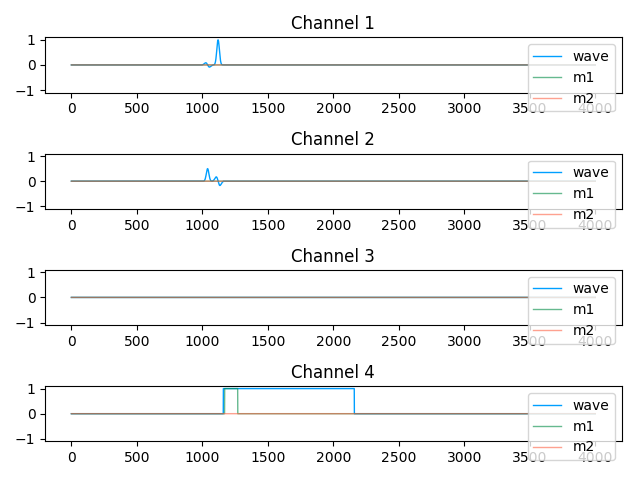

In [12]:
pl = allxy_seq.plot(elemnum=10, channels=[1, 2, 3, 4])